# LSTM Model

The LSTM model in this system is designed to forecast sensor readings of two sensors: R1 and R2. Using time series data from the sensors, the model captures how air conditions evolve over time during normal household activity.

The model runs in the cloud and processes incoming data in near real time. Model performance is evaluated using metrics such as MAE, RMSE, R², residual plot, and predicted vs actual curve for both R1 and R2 sensors.


### Environment Set Up

In [1]:
!git clone https://github.com/aladenisun/MSAAI_530_FinalProject

Cloning into 'MSAAI_530_FinalProject'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 58 (delta 13), reused 34 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 1.17 MiB | 6.75 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q -r /content/MSAAI_530_FinalProject/requirements.txt

In [4]:
import sys
import os

def in_colab():
    return "COLAB_GPU" in os.environ or "google.colab" in sys.modules

if in_colab():
    # running in Google Colab
    repo_path = "/content/MSAAI_530_FinalProject"
    data_path = "/content/MSAAI_530_FinalProject/data"

    # set working directory to the repo root
    os.chdir(repo_path)

else:
    # running locally in VS Code
    repo_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
    data_path = os.path.abspath(os.path.join(repo_path, "data"))

    # add repo root to Python path
    if repo_path not in sys.path:
        sys.path.append(repo_path)

    # set working directory to the repo root
    os.chdir(repo_path)

print("Using repo path:", repo_path)
print("Using data path:", data_path)
print("CWD:", os.getcwd())

Using repo path: /content/MSAAI_530_FinalProject
Using data path: /content/MSAAI_530_FinalProject/data
CWD: /content/MSAAI_530_FinalProject


In [5]:
# import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input

### Create Train, Validation, and Test Datasets

We trained the model on a segment of our data and then measured its performance on simulated streaming data another segment of the data. Using a chronological 80/20 spilt for the training and validation sets. The test split will come from the training data as part of the tensorflow LSTM model call.

In [12]:
dataset_csv = os.path.join(data_path, "Cleaned_HT_Sensor_Dataset.csv")

# load CSVs
df = pd.read_csv(dataset_csv, delimiter=",").dropna()

# focus only on the first two MOX gas sensors
feature_cols = ["R1", "R2"]
target_cols = ["R1", "R2"]

# create a copy of the dataframe
df_model = df[feature_cols].copy()

# chronological 80/20 split
split_idx = int(np.floor(0.8 * len(df_model)))

train_df = df_model.iloc[:split_idx].reset_index(drop=True)
val_df   = df_model.iloc[split_idx:].reset_index(drop=True)

print("Original head:\n", train_df.head())

print("Train data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

Original head:
         R1       R2
0  12.8621  10.3683
1  12.8617  10.3682
2  12.8607  10.3686
3  12.8602  10.3686
4  12.8595  10.3688
Train data shape: (10252, 2)
Validation data shape: (2563, 2)


### Create supervised sequences for forecasting

We created supervised sequences to allow the LSTM to learn the relationship between past sensor behavior and future readings. Time series data is inherently sequential, but neural networks require structured input target pairs during training. By using the previous 30 timesteps as input and predicting R1 and R2 senors five steps ahead, we teach the model to recognize temporal patterns and understand how current air quality trends evolve into future conditions.

We chose the previous 30 timesteps to give the LSTM enough historical context to learn meaningful temporal patterns in the sensor data. MOX gas sensors respond gradually to environmental changes, so short windows may miss important trends, while excessively long windows can introduce noise and increase overfitting. A 30 step window provides a balanced amount of recent history to capture rising or falling air quality patterns without making the model unnecessarily complex.

A predictive horizon of 5 steps was selected to forecast slightly ahead of the immediate next reading. Predicting multiple steps into the future encourages the model to learn underlying dynamics rather than simply copying the most recent value. This makes the forecasting task more realistic for near real-time monitoring and strengthens anomaly detection, since meaningful deviations between predicted and actual values become more apparent over a short future interval rather than just one timestep ahead.

In [13]:
seq_length = 30   # use last 30 timesteps to predict next step
horizon = 5     # predict next 5 steps ahead

target_idx = [feature_cols.index(c) for c in target_cols]

def create_sequences(data, seq_length, horizon, target_idx):
    """
    data: np.array shape (T, num_features)
    returns:
      X: (N, seq_length, num_features)
      y: (N, len(target_idx)) predicting next step targets
    """
    X, y = [], []
    T = len(data)
    for i in range(seq_length, T - horizon + 1):
        X.append(data[i - seq_length:i, :])
        y.append(data[i + horizon - 1, target_idx])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_df.values, seq_length, horizon, target_idx)
X_val,   y_val   = create_sequences(val_df.values,   seq_length, horizon, target_idx)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)

X_train: (10218, 30, 2) y_train: (10218, 2)
X_val:   (2529, 30, 2) y_val:   (2529, 2)


### Build LSTM Forecast Model

This LSTM architecture was intentionally designed to be lightweight while still capturing the temporal dynamics of the sensor data. The two stacked LSTM layers (16 and 8 units) allow the model to learn short-term and slightly longer-term patterns in air quality behavior without introducing excessive complexity. Because the dataset is moderate in size and the forecasting task involves only two continuous outputs (R1 and R2), a smaller architecture is sufficient to model the underlying trends. Reducing the number of hidden units lowers the number of trainable parameters, decreases computational cost, and improves generalization by limiting the risk of overfitting.

The Dense layer with a ReLU activation is used to introduce nonlinearity after temporal features are extracted by the LSTM layers. ReLU is computationally efficient, helps prevent vanishing gradient issues, and enables the model to represent nonlinear relationships in the sensor dynamics without adding significant overhead. The final layer remains linear because the task is regression, and mean squared error (MSE) is appropriate for continuous forecasting. Early stopping and adaptive learning rate scheduling further improve stability and prevent unnecessary training.

Overall, this architecture aligns well with the IoT system's goal of being lightweight and efficient, particularly for cloud deployment, where it can provide near real-time forecasting with minimal computational burden.

In [25]:
# define path to save model
model_path = "LSTM_model.keras"

# build the network
n_features = X_train.shape[-1]
nb_out = len(target_cols)

model = Sequential([
    Input(shape=(seq_length, n_features)),
    LSTM(16, return_sequences=True),
    Dropout(0.2),
    LSTM(8),
    Dense(8, activation="relu"),
    Dense(nb_out)
])

# set optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

# callbacks (early stopping + adaptive learning rate)
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,                 # stop earlier to prevent overfitting
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor="val_loss",
        save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# list all data in history
print(history.history.keys())

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 94.2596 - val_loss: 31.6777 - learning_rate: 0.0010
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 21.5709 - val_loss: 4.4649 - learning_rate: 0.0010
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 3.0914 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.2428 - val_loss: 0.2796 - learning_rate: 0.0010
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1.2215 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 1.1028 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.3585 - val_loss: 0.2319 - learning_rate: 0.0010
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.2889 - val_loss: 0.1814 - learning_rate: 0.0010
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.2766 - val_loss: 0.1832 - learning_rate: 0.00

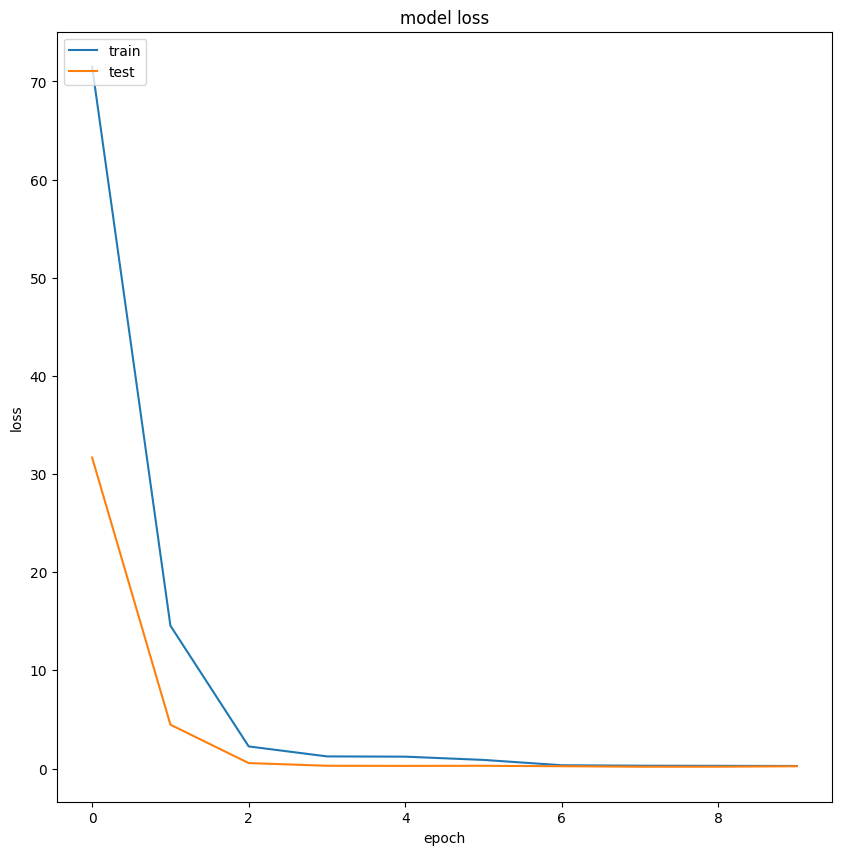

In [27]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(("model loss"))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The plot shows both training and validation loss decreasing rapidly during the first few epochs, indicating that the model is learning the underlying patterns quickly. The training loss starts high, drops sharply by the second epoch, and then gradually stabilizes at a very low value. The validation loss follows a similar trend, closely tracking the training curve without diverging. After approximately epoch 4–6, both curves flatten and remain stable, suggesting that the model has converged and is not exhibiting significant overfitting. The small and consistent gap between training and validation loss indicates good generalization performance.

### Validating Our Model

